# Fiting a ML algorithm on the prophages Dpo profiles to predict the KL type 
## I. Load tha data
> A. Sequence similarity <br>
> B. 3D structure similarity<br>
> C. Embeddings<br>
## II. Build the clusters
## III. Fit the algos on the data / Write performances
## IV. Plot the data
***

> Import the modules

In [ ]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import subprocess
from tqdm import tqdm
from collections import Counter
import datetime as dt
from Bio import SeqIO, Entrez, pairwise2


***
### I. Loading the data 

In [1]:
#import torch
import os 
import pandas as pd
from tqdm import tqdm 

# remote :
path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_tmp_cdhit = f"{path_work}/tmp_cdhit"

multi_fasta = f"{path_task}/Dpo_domains.0805.final.ultimate.multi.fasta"
df_info = pd.read_csv(f"{path_task}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
df_family = pd.read_csv(f"{path_task}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)
df_dpo_domain = pd.read_csv(f"{path_task}/Dpo_domains.0805.final.ultimate.tsv" , sep = "\t", header =0)

esm2_depo = pd.read_csv(f"{path_project}/Dpo.0805.embeddings.ultimate.csv" , header = None, sep = "," , index_col = 0)
#esm2_depo = esm2_depo.drop([1281], axis = 1)

family_df = pd.read_csv(f"{path_similarity}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)
df_info = pd.read_csv(f"{path_db}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)



/home/concha-eloko/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
# Sequence similarity

> Load Data

In [ ]:
import os 
import pandas as pd
from tqdm import tqdm 
from Bio import SeqIO
from multiprocessing.pool import ThreadPool

# remote :
path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_tmp_cdhit = f"{path_task}/sequence_similarity/tmp_cdhit"

path_multi_fasta = f"{path_task}/Dpo_domains.0805.final.ultimate.multi.fasta"
fasta_sequences = SeqIO.parse(path_multi_fasta, "fasta")

df_info = pd.read_csv(f"{path_task}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
df_family = pd.read_csv(f"{path_task}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)

> Clustering 

In [1]:
import subprocess
import numpy as np

def make_cdhit_cluster(threshold) :
    cdhit_command = f"cd-hit -i {path_multi_fasta} -o {path_tmp_cdhit}/{threshold}.out -c {threshold} -G 0 -aL 0.8"
    cdhit_process = subprocess.Popen(cdhit_command, shell =True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT) 
    scan_out, scan_err = cdhit_process.communicate()
    print(scan_out, scan_err)
    
thresholds_1 = np.arange(0.40 , 0.95 , 0.05)
thresholds_2 = np.arange(0.90 , 1.025 , 0.025)
thresholds = np.concatenate((thresholds_1 , thresholds_2))

list(map(make_cdhit_cluster , thresholds))

> Make DataFrame

In [ ]:
def make_cluster_dico(cdhit_out) :
    import json
    dico_cluster = {}
    threshold = cdhit_out.split("/")[-1].split(".out")[0]
    cluster_out = open(cdhit_out).read().split(">Cluster")
    for index,cluster in enumerate(cluster_out[1:]) :
        tmp_dpo = []
        id_cluster = f"Dpo_cdhit_{index}"
        for _,line in enumerate(cluster.split("\n")[1:-1]) :
            dpo = line.split(">")[1].split(".")[0]
            tmp_dpo.append(dpo)
        dico_cluster[id_cluster] = tmp_dpo
    with open(f"{path_task}/sequence_similarity/dico_cluster.cdhit__{threshold}.json", "w") as outfile:
        json.dump(dico_cluster, outfile)
    return dico_cluster , threshold
            
def make_Dpo_prophage_dico(dico_cluster) :
    dico_prophage_id = {}
    for Dpo_label , Dpo_list in tqdm(dico_cluster.items()) :
        prophages_carrying = set()
        for _,dpo in enumerate(Dpo_list) :
            prophages_df = df_info[df_info["index"] == dpo]
            for phage in prophages_df["Phage"].to_list() :
                family = df_family[df_family["prophage"] == f"{phage}.fasta"]["prophage_id"].values[0]
                prophages_carrying.add(family)
        dico_prophage_id[f"{Dpo_label}"] = prophages_carrying
    return dico_prophage_id
    
def build_dataframe(dico_prophage_id):
    prophages = set(prophage for prophages in dico_prophage_id.values() for prophage in prophages)
    matrix = [[1 if prophage in dico_prophage_id[dpo] else 0 for dpo in dico_prophage_id.keys()] for prophage in prophages]
    df_dpo_prophages = pd.DataFrame(matrix, index=prophages, columns=dico_prophage_id.keys())
    return df_dpo_prophages

def seq_similarity_df(cdhit_out) :
    dico_cluster , threshold = make_cluster_dico(cdhit_out)
    prophage_dico = make_Dpo_prophage_dico(dico_cluster)
    df_dpo_prophages = build_dataframe(prophage_dico)
    df_dpo_prophages.sort_index(inplace = True, ascending=True)
    df_dpo_prophages.to_csv(f"{path_task}/sequence_similarity/prophage_Dpo.cdhit_{threshold}.csv", sep = "\t")
    return df_dpo_prophages
    
path_cdhit = [f"{path_tmp_cdhit}/{file}" for file in os.listdir(path_tmp_cdhit) if file[-5:] == "clstr"]   
    
if __name__ == '__main__':
    with ThreadPool(10) as p:
        p.map(seq_similarity_df, path_cdhit)


> Little fixing

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/sequence_similarity/prophage_Dpo.cdhit_0.8.csv \
/media/concha-eloko/Linux/PPT_clean
    
    

In [1]:
import pandas as pd 
import os 

path_ppt = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/sequence_similarity"
df_cdhit = pd.read_csv(f"{path_ppt}/prophage_Dpo.cdhit_0.8.csv", sep = "\t", header = 0)

df_cdhit

FileNotFoundError: [Errno 2] No such file or directory: '/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/sequence_similarity/prophage_Dpo.cdhit_0.8.csv'

***
# 3D structure similarity

> Load data

In [ ]:
import os 
import pandas as pd
from tqdm import tqdm 
from Bio import SeqIO
from multiprocessing.pool import ThreadPool

# remote :
path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_tmp = f"{path_task}/3Dsequence_similarity/tmp_seekfold"
path_3D = f"{path_task}/3Dsequence_similarity/structures"

names_df_domain = ["index" , "index_seq", "fold", "prob","domain","dom_seq","full_seq"]
df_dpo_domain = pd.read_csv(f"{path_task}/Dpo_domains.0805.final.ultimate.tsv" , sep = "\t", names = names_df_domain)
df_info = pd.read_csv(f"{path_task}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
df_family = pd.read_csv(f"{path_task}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)


> Move the 3D structures into a structure files

In [ ]:
path_3D = f"{path_task}/3Dsequence_similarity/structures"
dico_path = {"ppt" : "sword2_DepoSeq_pt2", "minibatch" : "sword2_Minibatch_pt2"} 

for _,row in df_dpo_domain.iterrows() :
    try :
        db = row["index_seq"].split("__")[0]
        id_seq = row["index_seq"].split("__")[1]
        if row.domain == "full_protein" : 
            path_dom = f"{path_work}/{dico_path[db]}/{id_seq}/{id_seq}_A/SWORD/{id_seq}_A/{id_seq}_A.pdb"
        else :
            path_dom = f"{path_work}/{dico_path[db]}/{id_seq}/{id_seq}_A/Protein_Units/{row.domain}.pdb"
        cp_command = f"cp {path_dom} {path_3D}/{db}__{id_seq}.pdb"
        os.system(cp_command)
    except Exception as e :
        print(e , row)
        pass


> Clustering 

In [ ]:
import subprocess
import numpy as np

path_3D = f"{path_task}/3Dsequence_similarity/structures"
path_cluster = f"{path_task}/3Dsequence_similarity/clusters"

def make_seekfold(threshold) :
    foldseek_command = f"foldseek easy-cluster {path_3D} {path_cluster} {path_tmp} --cov-mode 0 -c {threshold}"    
    foldseek_process = subprocess.Popen(foldseek_command, shell =True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT) 
    scan_out, scan_err = foldseek_process.communicate()
    print(scan_out, scan_err)
    
thresholds_1 = np.arange(0.40 , 0.95 , 0.05)
thresholds_2 = np.arange(0.90 , 1.025 , 0.025)
thresholds = np.concatenate((thresholds_1 , thresholds_2))

list(map(make_seekfold , thresholds))

# *********************************************************** 
#!/bin/bash
#BATCH --job-name=foldseek__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=40 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=foldseek__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate clustering

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3Dsequence_similarity/cluster.py

> Make dataframe 

In [ ]:
def make_cluster_dico(foldseek_out) :
    import json
    dico_cluster = {}
    threshold = foldseek_out.split("/")[-1].split("_")[1]
    df_clusters = pd.read_csv(f"{foldseek_out}", sep = "\t", names = ["Leader", "Member"])
    clusters_leader = list(df_clusters["Leader"].unique())
    for index, leader in enumerate(clusters_leader) :
        tmp_dpo = []
        id_cluster = f"Dpo_foldseek_{index}"
        df_cluster = df_clusters[df_clusters["Leader"] == leader]
        for _,row in df_cluster.iterrows() :
            tmp_dpo.append(row["Member"].split(".pdb")[0])
        dico_cluster[id_cluster] = tmp_dpo
    with open(f"{path_task}/3Dsequence_similarity/dico_cluster.foldseek__{threshold}.json", "w") as outfile:
        json.dump(dico_cluster, outfile)
    return dico_cluster , threshold
            
            
def make_Dpo_prophage_dico(dico_cluster) :
    dico_prophage_id = {}
    for Dpo_label , Dpo_list in tqdm(dico_cluster.items()) :
        prophages_carrying = set()
        for _,dpo in enumerate(Dpo_list) :
            prophages_df = df_info[df_info["index"] == dpo]
            for phage in prophages_df["Phage"].to_list() :
                family = df_family[df_family["prophage"] == f"{phage}.fasta"]["prophage_id"].values[0]
                prophages_carrying.add(family)
        dico_prophage_id[f"{Dpo_label}"] = prophages_carrying
    return dico_prophage_id
    
def build_dataframe(dico_prophage_id):
    prophages = set(prophage for prophages in dico_prophage_id.values() for prophage in prophages)
    matrix = [[1 if prophage in dico_prophage_id[dpo] else 0 for dpo in dico_prophage_id.keys()] for prophage in prophages]
    df_dpo_prophages = pd.DataFrame(matrix, index=prophages, columns=dico_prophage_id.keys())
    return df_dpo_prophages

def seq_similarity_df(cdhit_out) :
    dico_cluster , threshold = make_cluster_dico(cdhit_out)
    prophage_dico = make_Dpo_prophage_dico(dico_cluster)
    df_dpo_prophages = build_dataframe(prophage_dico)
    df_dpo_prophages.sort_index(inplace = True, ascending=True)
    df_dpo_prophages.to_csv(f"{path_task}/3Dsequence_similarity/prophage_Dpo.foldseek_{threshold}.csv", sep = "\t")
    return df_dpo_prophages
    
seq_similarity_df(path_foldseek[0])
path_foldseek = [f"{path_cluster}/{file}" for file in os.listdir(path_cluster) if file[-11:] == "cluster.tsv"]   
    
if __name__ == '__main__':
    with ThreadPool(10) as p:
        p.map(seq_similarity_df, path_foldseek)

***
# Embeddings

> Load data

In [14]:
import os 
import pandas as pd
from tqdm import tqdm 
from multiprocessing.pool import ThreadPool

# remote :
path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_embeddings = f"{path_task}/embeddings"

esm2_depo = pd.read_csv(f"{path_task}/Dpo.0805.embeddings.ultimate.csv" , header = None, sep = "," , index_col = 0)


,1,2,3,4,5,6,7,8,9,10,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280
0,,,,,,,,,,,,,,,,,,,,,
ppt__2930,-0.000061,-0.017329,0.012884,0.037123,-0.123747,0.004186,-0.061367,-0.056718,-0.037215,0.017796,...,0.098806,0.012989,-0.001155,0.139749,-0.030987,0.059306,0.107041,-0.041463,-0.085581,0.114973
ppt__3300,0.004044,0.040011,-0.001234,-0.095745,-0.058056,-0.002394,0.007648,-0.059740,0.060850,0.027698,...,-0.020369,0.016287,0.062586,-0.024336,0.019276,0.069623,0.035261,-0.118962,0.035672,0.085582
ppt__1182,0.018767,0.068116,-0.009109,-0.012598,-0.107001,0.011569,-0.030943,-0.045359,0.048923,0.032816,...,0.014524,-0.024645,0.071878,0.018206,0.042790,0.088410,0.031970,-0.124592,0.070040,0.065348
ppt__3540,-0.028261,-0.047253,-0.027340,-0.052824,-0.089644,-0.023079,0.094861,0.026104,0.024001,0.089394,...,0.051728,0.005634,-0.077874,0.030336,-0.037648,0.050625,0.046142,-0.158841,-0.007670,0.034556
ppt__942,0.014863,0.028030,0.014927,-0.025997,-0.096138,0.016290,0.015008,-0.066254,0.077959,0.057165,...,0.008521,-0.019820,0.123201,-0.040306,0.030893,0.051362,0.047316,-0.102698,0.044830,0.084530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
minibatch__1547,0.005586,0.022056,0.009792,-0.036183,-0.103171,0.028859,0.023063,-0.054788,0.088813,0.042841,...,-0.002956,-0.022535,0.096137,-0.023147,0.028822,0.064896,0.046402,-0.103289,0.030545,0.080931
ppt__2719,0.008973,-0.036172,0.024278,-0.005935,-0.089380,0.007263,0.032040,-0.216239,0.071972,0.054308,...,0.066656,0.034687,-0.021256,-0.080038,-0.082435,0.010141,0.103680,-0.086817,-0.067720,0.096804
minibatch__752,-0.007236,0.063871,-0.010960,-0.047293,-0.074936,0.014609,0.007950,-0.075715,0.072990,0.066386,...,0.008046,-0.022476,0.103217,-0.005581,0.036304,0.078642,0.037012,-0.096549,0.055382,0.070137


> Clustering

In [ ]:
# What range for the preference ? 

def make_aff_clustering_dico(preference) :
    # Affinity propagation step :
    af = AffinityPropagation(damping=0.95, preference=preference, random_state=123, max_iter=1000,verbose=True).fit(esm2_depo)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    print(f"There are {n_clusters_} for the preference {preference}")
    
make_aff_clustering_dico(-0.3)

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import json

thresholds_1 = list(np.arange(-0.5 , 0.05 , 0.05).round(3))
thresholds = thresholds_1 + [-0.01]


def make_aff_clustering_dico(preference) :
    # Affinity propagation step :
    af = AffinityPropagation(damping=0.95, preference=preference, random_state=123, max_iter=1000,verbose=True).fit(esm2_depo)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    # Make dico : 
    dico_df = {"Dpo" : esm2_depo.index , "Label" : labels}
    df_results = pd.DataFrame(dico_df)
    dico_cluster = {}
    for index , row in df_results.iterrows() :
        real_label = f"Dpo_embeddings_{row['Label']}"
        if real_label not in dico_cluster :
            tmp_list = []
            tmp_list.append(row["Dpo"])
            dico_cluster[real_label] = tmp_list
        else :
            dico_cluster[real_label].append(row["Dpo"])
    with open(f"{path_embeddings}/dico_cluster.embeddings_{preference}.json", "w") as outfile:
        json.dump(dico_cluster, outfile)
    return dico_cluster , preference

def make_Dpo_prophage_dico(dico_cluster) :
    dico_prophage_id = {}
    for Dpo_label , Dpo_list in tqdm(dico_cluster.items()) :
        prophages_carrying = set()
        for _,dpo in enumerate(Dpo_list) :
            prophages_df = df_info[df_info["index"] == dpo]
            for phage in prophages_df["Phage"].to_list() :
                family = df_family[df_family["prophage"] == f"{phage}.fasta"]["prophage_id"].values[0]
                prophages_carrying.add(family)
        dico_prophage_id[f"{Dpo_label}"] = prophages_carrying
    return dico_prophage_id
    
def build_dataframe(dico_prophage_id):
    prophages = set(prophage for prophages in dico_prophage_id.values() for prophage in prophages)
    matrix = [[1 if prophage in dico_prophage_id[dpo] else 0 for dpo in dico_prophage_id.keys()] for prophage in prophages]
    df_dpo_prophages = pd.DataFrame(matrix, index=prophages, columns=dico_prophage_id.keys())
    return df_dpo_prophages

def seq_similarity_df(preference) :
    dico_cluster , preference = make_aff_clustering_dico(preference)
    prophage_dico = make_Dpo_prophage_dico(dico_cluster)
    df_dpo_prophages = build_dataframe(prophage_dico)
    df_dpo_prophages.sort_index(inplace = True, ascending=True)
    df_dpo_prophages.to_csv(f"{path_task}/embeddings/prophage_Dpo.embeddings_{preference}.csv", sep = "\t")
    return df_dpo_prophages
    
thresholds_1 = list(np.arange(-0.5 , 0.05 , 0.05).round(3))
thresholds = thresholds_1 + [-0.01]

if __name__ == '__main__':
    with ThreadPool(10) as p:
        p.map(seq_similarity_df, thresholds)
        


> Little extra fixing :

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import json
import os 
import pandas as pd
from tqdm import tqdm 

# remote :
path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"

df_info = pd.read_csv(f"{path_work}/DF_Dpo.final.2705.tsv" , sep = "\t" , header = 0)
df_family = pd.read_csv(f"{path_task}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)
esm2_depo = pd.read_csv(f"{path_work}/Dpo.2705.embeddings.ultimate.csv" , header = None, sep = "," , index_col = 0)
#esm2_depo = esm2_depo.drop([1281], axis = 1)

old_indices = [dpo for dpo in  esm2_depo.index if dpo[0] != "a"]
old_esm2 = esm2_depo[esm2_depo.index.isin(old_indices)]
old_df_info = df_info[df_info["index"].isin(old_indices)]

def make_aff_clustering_dico(preference) :
    # Affinity propagation step :
    af = AffinityPropagation(damping=0.95, preference=preference, random_state=123, max_iter=1000,verbose=True).fit(esm2_depo)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    # Make dico : 
    dico_df = {"Dpo" : esm2_depo.index , "Label" : labels}
    df_results = pd.DataFrame(dico_df)
    dico_cluster = {}
    for index , row in df_results.iterrows() :
        real_label = f"Dpo_embeddings_{row['Label']}"
        if real_label not in dico_cluster :
            tmp_list = []
            tmp_list.append(row["Dpo"])
            dico_cluster[real_label] = tmp_list
        else :
            dico_cluster[real_label].append(row["Dpo"])
    with open(f"{path_embeddings}/dico_cluster.embeddings_{preference}.0606.complete.json", "w") as outfile:
        json.dump(dico_cluster, outfile)
    return dico_cluster , preference

def make_Dpo_prophage_dico(dico_cluster) :
    dico_prophage_id = {}
    for Dpo_label , Dpo_list in tqdm(dico_cluster.items()) :
        prophages_carrying = set()
        for _,dpo in enumerate(Dpo_list) :
            prophages_df = df_info[df_info["index"] == dpo]
            for phage in prophages_df["Phage"].to_list() :
                family = df_family[df_family["prophage"] == f"{phage}.fasta"]["prophage_id"].values[0]
                prophages_carrying.add(family)
        dico_prophage_id[f"{Dpo_label}"] = prophages_carrying
    return dico_prophage_id
    
def build_dataframe(dico_prophage_id):
    prophages = set(prophage for prophages in dico_prophage_id.values() for prophage in prophages)
    matrix = [[1 if prophage in dico_prophage_id[dpo] else 0 for dpo in dico_prophage_id.keys()] for prophage in prophages]
    df_dpo_prophages = pd.DataFrame(matrix, index=prophages, columns=dico_prophage_id.keys())
    return df_dpo_prophages

def seq_similarity_df(preference) :
    dico_cluster , preference = make_aff_clustering_dico(preference)
    prophage_dico = make_Dpo_prophage_dico(dico_cluster)
    df_dpo_prophages = build_dataframe(prophage_dico)
    df_dpo_prophages.sort_index(inplace = True, ascending=True)
    df_dpo_prophages.to_csv(f"{path_task}/embeddings/prophage_Dpo.embeddings_{preference}.0606.complete.csv", sep = "\t")
    return df_dpo_prophages
    
for pref in [-0.5,-0.8] :
    seq_similarity_df(pref)

# *********************************************************    
#!/bin/bash
#BATCH --job-name=embeddings_aff__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=5 
#SBATCH --mem=10gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=embeddings_aff__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate clustering

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/script_files/last_csv.complete.py

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings/prophage_Dpo.embeddings_-0.8.0606.reduced.csv \
/media/concha-eloko/Linux/PPT_clean

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings/prophage_Dpo.embeddings_-0.8.0606.complete.csv \
/media/concha-eloko/Linux/PPT_clean

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/DF_prophage_ID.KLtypes.0606.csv \
/media/concha-eloko/Linux/PPT_clean



In [ ]:
import json 

dico_prophage_id = json.load(open(f"{path_task}/dico_prophage_ID.KLtypes.json"))
df_prophages = build_dataframe(dico_prophage_id)
df_trans = df_prophages.T

df_trans_reindexed.to_csv(f"{path_task}/DF_prophage_ID.KLtypes.0606.csv", index = True, sep = "\t")


In [ ]:
# *********************************************************** 
#!/bin/bash
#BATCH --job-name=embeddings_aff__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=40 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=embeddings_aff__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate clustering

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings/make_csv.py

***
# Running the algorithms : LR ; RF ; SVM ; NN ?

In [ ]:
import os 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm 
from multiprocessing import Pool, cpu_count

path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_embeddings = f"{path_task}/embeddings"
path_3D = f"{path_task}/3Dsequence_similarity"
path_aa_seq = f"{path_task}/sequence_similarity"

df_info = pd.read_csv(f"{path_task}/DF_Dpo.final.1005.tsv" , sep = "\t", header =0)
df_family = pd.read_csv(f"{path_task}/clusters_99_80.extra_clean.2004.v2.tsv", sep = "\t", header = 0)

index_dico = {"cdhit" : "seq_similarity" , "foldseek" : "3D_similarity" , "embeddings" : "embeddings_similarity"}

# create the auxiliary column without the ".fasta" part
df_family['prophage_aux'] = df_family['prophage'].str.split('.fasta').str[0]

# merge the dataframes using the auxiliary column and Phage
merged_df = pd.merge(df_family, df_info, left_on='prophage_aux', right_on='Phage', how='left')

def process_prophage(prophage_id):
    ktypes = set()
    phages = merged_df[merged_df["prophage_id"] == prophage_id]
    ktypes.update(phages['KL_type_LCA'].dropna().apply(lambda x: x if "|" not in x else None))
    return prophage_id, list(ktypes) if len(ktypes) > 0 else None

# Utilizing multiprocessing to speed up the process
with Pool(10) as p:
    dico_KL_prophage_id = dict(filter(lambda x: x[1] is not None, p.map(process_prophage, tqdm(df_family["prophage_id"].unique()))))

with open(f"{path_task}/dico_prophage_ID.KLtypes.json", "w") as outfile:
    json.dump(dico_KL_prophage_id, outfile) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report , roc_auc_score
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np
from collections import Counter

import os 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm 
from multiprocessing.pool import ThreadPool 

path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_embeddings = f"{path_task}/embeddings"
path_3D = f"{path_task}/3Dsequence_similarity"
path_aa_seq = f"{path_task}/sequence_similarity"

path_methods = [path_embeddings , path_3D , path_aa_seq]

path_dfs = []
for method in path_methods :
    for file in os.listdir(method) :
        if file[-3:] == "csv" :
            f_path = f"{method}/{file}"
            path_dfs.append(f_path)

index_dico = {"cdhit" : "seq_similarity" , "foldseek" : "3D_similarity" , "embeddings" : "embeddings_similarity"}

def make_df_type(path_df) :
    df = pd.read_csv(f"{path_df}" , sep = "\t" , header = 0 , index_col = 0)
    method = index_dico[path_df.split("/")[-1].split("_")[1].split(".")[1]]
    threshold = path_df.split("/")[-1].split("_")[-1].split(".csv")[0]
    dico_KL_prophage_id = json.load(open(f"{path_task}/dico_prophage_ID.KLtypes.json"))
    labels = []
    for index in df.index:
        label = dico_KL_prophage_id.get(index, np.nan)
        if len(label) == 1 :
            labels.append(label[0])
        else :
            labels.append("Multiple")
    df["label"] = labels
    df = df[df['label'] != 'Multiple']
    return df , method , threshold

    
def fit_rf_model_random_search(df):
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["label"])
    n_iter=2
    X_train, X_test, y_train, y_test = train_test_split(df, df["label"], test_size=0.2, random_state=42)
    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800]
    }
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=n_iter, cv=4, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    # Print the best parameters from the Randomized Search
    predictions = rf_random.predict(X_test)
    proba = rf_random.predict_proba(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    #auc = roc_auc_score(y_test, proba, multi_class='ovr')
    accuracy = report["accuracy"]
    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_F1 = report["weighted avg"]["f1-score"]
    mcc = matthews_corrcoef(y_test, predictions)
    return mcc
    
        

def fit_RF_file(path_df) :
    df , method , threshold = make_df_type(path_df)
    weighted_precision ,  weighted_recall , weighted_F1  = fit_rf_model_random_search(df)
    with open(f"{path_task}/{method}_RF_report.tsv", "a+") as outfile :
        outfile.write(f"{method}\t{threshold}\t{weighted_precision}\t{weighted_recall}\t{weighted_F1}\n")
    #return weighted_precision ,  weighted_recall , weighted_F1  , method
    

if __name__ == '__main__':
    with ThreadPool(10) as p:
        p.map(fit_RF_file, path_dfs)
        
# ****************************************************************************************
#!/bin/bash
#BATCH --job-name=RF__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=30 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=RF__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate python_311

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/script_files/fit_RF.py

***
# Select the best model for each method :

> Move the files around :

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3D_similarity_RF_report.tsv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings_similarity_RF_report.tsv \
/media/concha-eloko/Linux/PPT_clean   
    
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/seq_similarity_RF_report.tsv \
/media/concha-eloko/Linux/PPT_clean

***
# Plot the distribution of F1 score

In [13]:
import pandas as pd 
import os 
path_project = "/media/concha-eloko/Linux/PPT_clean"

names_report = ["Method" , "Threshold", "Precision","Recall","F1_score"]
df_3D = pd.read_csv(f"{path_project}/3D_similarity_RF_report.tsv", names = names_report, sep = "\t")
df_3D.sort_values(by = ["Threshold"] , inplace = True)

df_aa_seq = pd.read_csv(f"{path_project}/seq_similarity_RF_report.tsv", names = names_report, sep = "\t")
df_aa_seq.sort_values(by = ["Threshold"] , inplace = True)

df_emb = pd.read_csv(f"{path_project}/embeddings_similarity_RF_report.tsv", names = names_report, sep = "\t")
df_emb.sort_values(by = ["Threshold"] , inplace = True)

DFs = [df_emb , df_aa_seq , df_3D]

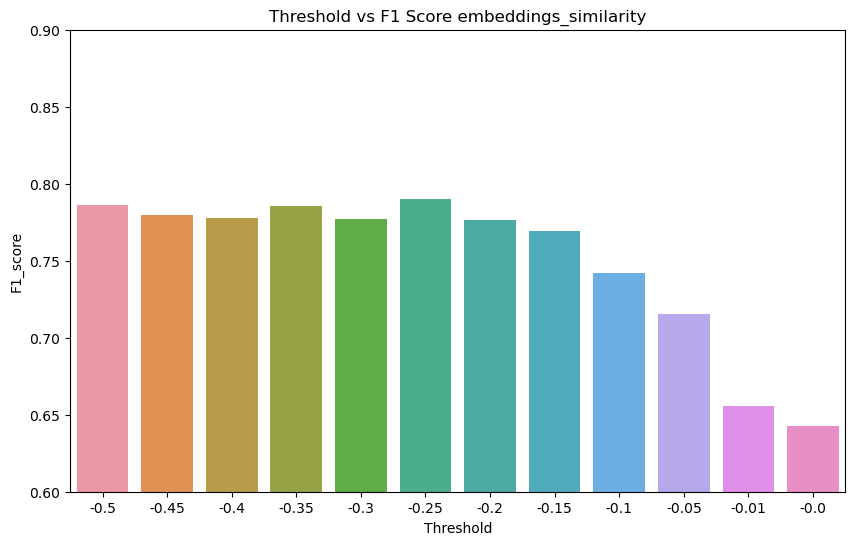

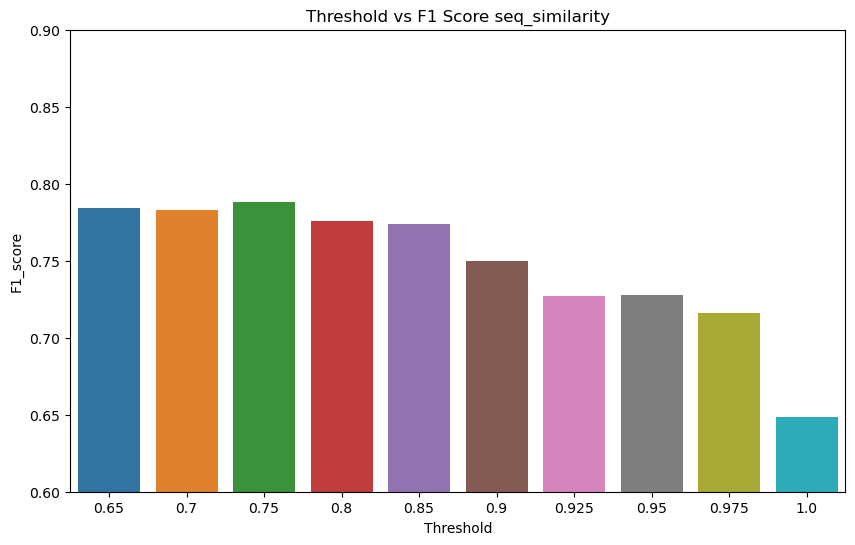

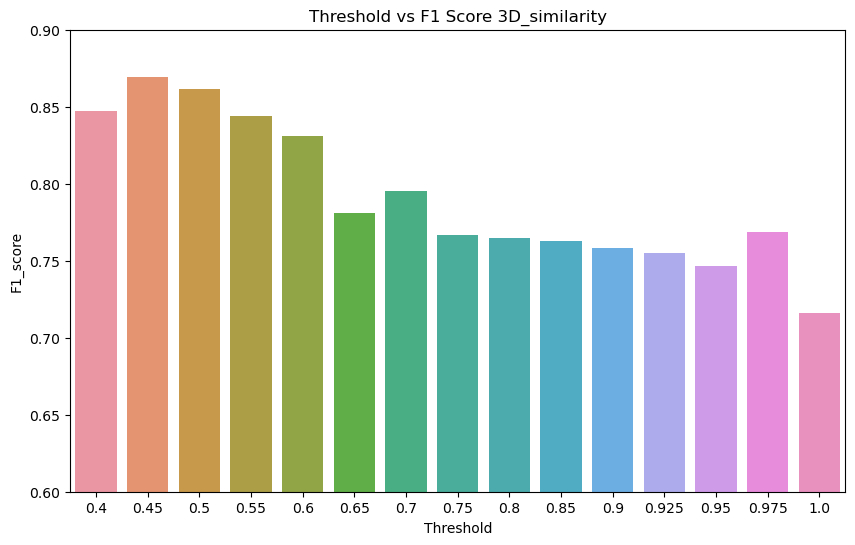

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

for df in DFs : 
    method = df["Method"]
    df['Threshold'] = df['Threshold'].apply(str)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Threshold", y="F1_score", data=df, ci=None)
    # Set the limits of y-axis
    plt.ylim(0.6, 0.9)
    plt.title(f'Threshold vs F1 Score {df["Method"][0]}')
    plt.savefig(f"{path_project}/{df['Method'][0]}_F1score_thesholds.png")
    plt.show()

> Get the best DF for each method

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3Dsequence_similarity/prophage_Dpo.foldseek_0.45.csv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings/prophage_Dpo.embeddings_-0.25.csv \
/media/concha-eloko/Linux/PPT_clean   
    
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/sequence_similarity/prophage_Dpo.cdhit_0.75.csv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/dico_prophage_ID.KLtypes.json \
/media/concha-eloko/Linux/PPT_clean
    

> Fit the model locally : 

In [38]:
import pandas as pd 
import os 
import json

path_project = "/media/concha-eloko/Linux/PPT_clean"

df_3D = pd.read_csv(f"{path_project}/prophage_Dpo.foldseek_0.45.csv", sep = "\t", index_col = 0)
df_aa_seq = pd.read_csv(f"{path_project}/prophage_Dpo.cdhit_0.75.csv", sep = "\t", index_col = 0)
df_emb = pd.read_csv(f"{path_project}/prophage_Dpo.embeddings_-0.25.csv", sep = "\t", index_col = 0)

dico_KL_type = json.load(open(f"{path_project}/dico_prophage_ID.KLtypes.json"))
KL_types = set(values[0] for values in dico_KL_type.values())


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import fisher_exact
import pandas as pd 
import os 
import json
import numpy as np
from collections import Counter
from multiprocessing.pool import ThreadPool 

#path_project = "/media/concha-eloko/Linux/PPT_clean"
path_project = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task"

dico_KL_type = json.load(open(f"{path_project}/dico_prophage_ID.KLtypes.json"))
KL_types = set(values[0] for values in dico_KL_type.values())


dico_names = {"prophage_Dpo.cdhit_0.75.csv" : "aa_seq" ,
             "prophage_Dpo.embeddings_-0.25.csv" : "embeddings",
             "prophage_Dpo.foldseek_0.45.csv" : "3D"}

paths_df = [f"{path_project}/prophage_Dpo.foldseek_0.45.csv" , f"{path_project}/prophage_Dpo.cdhit_0.75.csv" , f"{path_project}/prophage_Dpo.embeddings_-0.25.csv"]


def fit_rf_model_random_search(label):
    for path_df in paths_df : 
        try : 
            file = path_df.split("/")[-1]
            df = pd.read_csv(f"{path_df}", sep = "\t", index_col = 0)
            df["Labels"] = df.index.to_series().map(lambda x : 1 if label in dico_KL_type.get(x, []) else 0)
            X = df.drop(["Labels"] , axis = 1)
            n_iter=10
            X_train, X_test, y_train, y_test = train_test_split(X, df["Labels"], test_size=0.2, random_state=42)
            param_grid = {
                    'bootstrap': [True, False],
                    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [200, 400, 600, 800]
                }
            rf = RandomForestClassifier()
            rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                           n_iter=n_iter, cv=4, verbose=2, random_state=42, n_jobs=-1)
            rf_random.fit(X_train, y_train)
            # Print the best parameters from the Randomized Search
            predictions = rf_random.predict(X_test)
            report = classification_report(y_test, predictions, output_dict=True)
            with open(f"{path_project}/{dico_names[file]}.KL_report.tsv", "a+") as outfile : 
                outfile.write(f"{label}\t{report['1']['precision']}\t{report['1']['recall']}\t{report['1']['f1-score']}\t{report['1']['support']}\n")
        except Exception as e :
            with open(f"{path_project}/{dico_names[file]}.KL_report.tsv", "a+") as outfile : 
                outfile.write(f"{label}\tFailed\n")


if __name__ == '__main__':
    with ThreadPool(15) as p:
        p.map(fit_rf_model_random_search, KL_types)
        
# ****************************************************************************************
#!/bin/bash
#BATCH --job-name=RF__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=30 
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=RF__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate python_311

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/script_files/report_KL.py

Fitting 4 folds for each of 10 candidates, totalling 40 fits
{'0': {'precision': 0.994750656167979, 'recall': 1.0, 'f1-score': 0.9973684210526316, 'support': 379}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.994750656167979, 'macro avg': {'precision': 0.4973753280839895, 'recall': 0.5, 'f1-score': 0.4986842105263158, 'support': 381}, 'weighted avg': {'precision': 0.9895288679466248, 'recall': 0.994750656167979, 'f1-score': 0.9921328912833265, 'support': 381}}


/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50,

/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=

/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=

/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   1.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   1.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=

/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/concha-eloko/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

***
# Plot the F1 score for each KL type 

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3D.KL_report.tsv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings.KL_report.tsv \
/media/concha-eloko/Linux/PPT_clean   

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/aa_seq.KL_report.tsv \
/media/concha-eloko/Linux/PPT_clean

In [1]:
import pandas as pd 
import os 
import json

path_project = "/media/concha-eloko/Linux/PPT_clean"

names_report = ["Label" , "Precision", "Recall", "F1_score","Support"]
df_3D = pd.read_csv(f"{path_project}/3D.KL_report.tsv", sep = "\t", names = names_report).fillna(0)
df_3D.sort_values(by = ["F1_score"] , inplace = True , ascending = False)

df_aa_seq = pd.read_csv(f"{path_project}/aa_seq.KL_report.tsv", sep = "\t", names = names_report).fillna(0)
df_aa_seq.sort_values(by = ["F1_score"] , inplace = True, ascending = False)

df_emb = pd.read_csv(f"{path_project}/embeddings.KL_report.tsv", sep = "\t", names = names_report).fillna(0)
df_emb.sort_values(by = ["F1_score"] , inplace = True, ascending = False)

df_real = pd.read_csv(f"{path_project}/embeddings_real.KL_report.tsv", sep = "\t", names = names_report).fillna(0)
df_real.sort_values(by = ["F1_score"] , inplace = True, ascending = False)

DFs = [df_3D , df_aa_seq , df_emb]

#method_dico = {df_3D : "3D" , df_aa_seq : "aa_seq", df_emb : "embeddings"}

In [48]:
df_aa_seq[df_aa_seq["Label"] == "KL18"]

,Label,Precision,Recall,F1_score,Support
124,KL18,1.0,1.0,1.0,2.0


In [9]:
import pprint
pp = pprint.PrettyPrinter(compact = True, width = 150,sort_dicts=True)

pp.pprint(set(df_3D.Label))

{'KL1', 'KL10', 'KL101', 'KL102', 'KL103', 'KL104', 'KL105', 'KL106', 'KL107', 'KL108', 'KL109', 'KL11', 'KL110', 'KL111', 'KL112', 'KL113', 'KL114',
 'KL115', 'KL116', 'KL117', 'KL118', 'KL119', 'KL12', 'KL120', 'KL121', 'KL122', 'KL123', 'KL124', 'KL125', 'KL126', 'KL127', 'KL128', 'KL13',
 'KL130', 'KL131', 'KL132', 'KL133', 'KL134', 'KL136', 'KL137', 'KL138', 'KL139', 'KL14', 'KL140', 'KL141', 'KL142', 'KL143', 'KL144', 'KL145',
 'KL146', 'KL147', 'KL148', 'KL149', 'KL15', 'KL150', 'KL151', 'KL152', 'KL153', 'KL154', 'KL155', 'KL157', 'KL158', 'KL159', 'KL16', 'KL162',
 'KL163', 'KL164', 'KL165', 'KL166', 'KL169', 'KL17', 'KL170', 'KL18', 'KL19', 'KL2', 'KL20', 'KL21', 'KL22', 'KL23', 'KL24', 'KL25', 'KL26', 'KL27',
 'KL28', 'KL29', 'KL3', 'KL30', 'KL31', 'KL33', 'KL34', 'KL35', 'KL36', 'KL37', 'KL38', 'KL39', 'KL4', 'KL40', 'KL41', 'KL42', 'KL43', 'KL45', 'KL46',
 'KL47', 'KL48', 'KL49', 'KL5', 'KL50', 'KL51', 'KL52', 'KL53', 'KL54', 'KL55', 'KL56', 'KL57', 'KL58', 'KL59', 'KL6', 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(method , df) :
    df_filtered = df[df['F1_score'] != 0]
    plt.figure(figsize=(12, 6))
    # Use stripplot to add individual data points
    sns.boxplot(x='Label', y='F1_score', data=df_filtered, color='skyblue')
    sns.stripplot(x='Label', y='F1_score', data=df_filtered, color='darkblue', size=6, jitter=True)
    plt.title('F1_score of the RF model by KL_type', fontsize=16)
    plt.xlabel('KL_type', fontsize=14)
    plt.ylabel('F1_score', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)  # Rotates x-axis labels to be vertical
    # Make the grid visible
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{path_project}/F1_score.KLtype.{method}.png", dpi =300)
    plt.show()

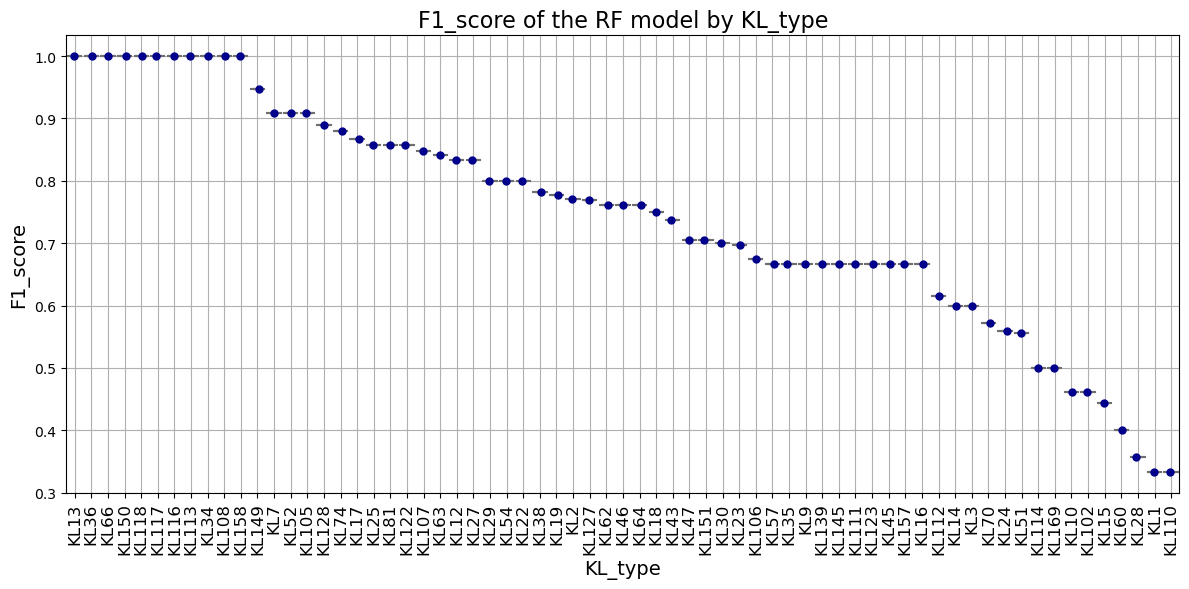

In [10]:
#method_dico = {df_3D : "3D" , df_aa_seq : "aa_seq", df_emb : "embeddings"}
make_plot("emb_real" , df_real)

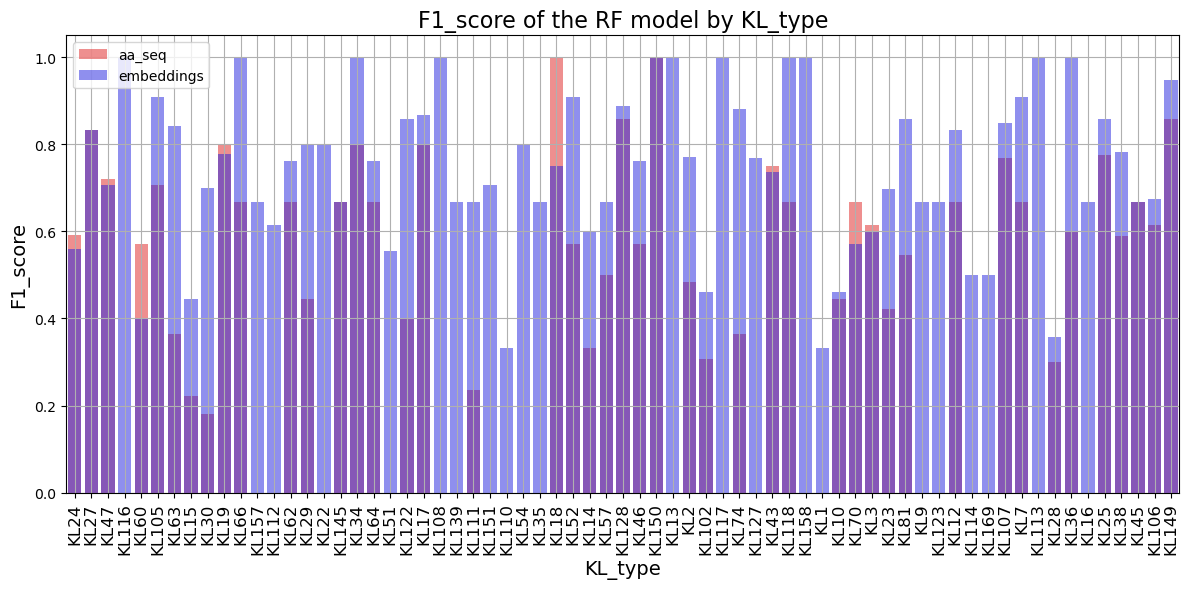

In [42]:
excluded = ["KL4", "KL140","KL153"]

def make_plot(method , df1, df2) :
    df1_filtered = df1[(df1['F1_score'] != 0) & (df1["Support"] >=0) & (~df1["Label"].isin(excluded))]
    df2_filtered = df2[(df2['F1_score'] != 0) & (df2["Support"] >=0) & (~df2["Label"].isin(excluded))]

    # Set of all unique labels across both dataframes
    all_labels = set(df1_filtered['Label']).union(df2_filtered['Label'])

    # Align both dataframes to include all labels
    df1_aligned = df1_filtered.set_index('Label').reindex(all_labels, fill_value=0).reset_index()
    df2_aligned = df2_filtered.set_index('Label').reindex(all_labels, fill_value=0).reset_index()

    plt.figure(figsize=(12, 6))
    # Create two barplots
    sns.barplot(x='Label', y='F1_score', data=df1_aligned, color='red', alpha=0.5, label="aa_seq")
    sns.barplot(x='Label', y='F1_score', data=df2_aligned, color='blue', alpha=0.5, label="embeddings")

    plt.title('F1_score of the RF model by KL_type', fontsize=16)
    plt.xlabel('KL_type', fontsize=14)
    plt.ylabel('F1_score', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)  # Rotates x-axis labels to be vertical
    # Make the grid visible
    plt.grid(True)
    plt.legend()  # Add legend
    plt.tight_layout()
    plt.savefig(f"{path_project}/F1_score.KLtype.{method}.png", dpi =300)
    plt.show()
    
make_plot("realEmbeddings_vs_aa_seqcluster" ,df_aa_seq, df_real)

***
# The report with the values for each model : 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report , roc_auc_score, matthews_corrcoef , confusion_matrix
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np
from collections import Counter

import os 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm 
from multiprocessing.pool import ThreadPool 

path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_embeddings = f"{path_task}/embeddings"
path_3D = f"{path_task}/3Dsequence_similarity"
path_aa_seq = f"{path_task}/sequence_similarity"

path_methods = [path_embeddings , path_3D , path_aa_seq]

path_dfs = []
for method in path_methods :
    for file in os.listdir(method) :
        if file[-3:] == "csv" :
            f_path = f"{method}/{file}"
            path_dfs.append(f_path)

index_dico = {"cdhit" : "seq_similarity" , "foldseek" : "3D_similarity" , "embeddings" : "embeddings_similarity"}

KLtypes = ['KL1', 'KL10', 'KL101', 'KL102', 'KL103', 'KL104', 'KL105', 'KL106', 'KL107', 'KL108', 'KL109', 'KL11', 'KL110', 'KL111', 'KL112', 'KL113', 'KL114',
 'KL115', 'KL116', 'KL117', 'KL118', 'KL119', 'KL12', 'KL120', 'KL121', 'KL122', 'KL123', 'KL124', 'KL125', 'KL126', 'KL127', 'KL128', 'KL13',
 'KL130', 'KL131', 'KL132', 'KL133', 'KL134', 'KL136', 'KL137', 'KL138', 'KL139', 'KL14', 'KL140', 'KL141', 'KL142', 'KL143', 'KL144', 'KL145',
 'KL146', 'KL147', 'KL148', 'KL149', 'KL15', 'KL150', 'KL151', 'KL152', 'KL153', 'KL154', 'KL155', 'KL157', 'KL158', 'KL159', 'KL16', 'KL162',
 'KL163', 'KL164', 'KL165', 'KL166', 'KL169', 'KL17', 'KL170', 'KL18', 'KL19', 'KL2', 'KL20', 'KL21', 'KL22', 'KL23', 'KL24', 'KL25', 'KL26', 'KL27',
 'KL28', 'KL29', 'KL3', 'KL30', 'KL31', 'KL33', 'KL34', 'KL35', 'KL36', 'KL37', 'KL38', 'KL39', 'KL4', 'KL40', 'KL41', 'KL42', 'KL43', 'KL45', 'KL46',
 'KL47', 'KL48', 'KL49', 'KL5', 'KL50', 'KL51', 'KL52', 'KL53', 'KL54', 'KL55', 'KL56', 'KL57', 'KL58', 'KL59', 'KL6', 'KL60', 'KL61', 'KL62', 'KL63',
 'KL64', 'KL66', 'KL67', 'KL7', 'KL70', 'KL71', 'KL74', 'KL8', 'KL80', 'KL81', 'KL82', 'KL9']

def make_df_type(path_df) :
    df = pd.read_csv(f"{path_df}" , sep = "\t" , header = 0 , index_col = 0)
    method = index_dico[path_df.split("/")[-1].split("_")[1].split(".")[1]]
    threshold = path_df.split("/")[-1].split("_")[-1].split(".csv")[0]
    dico_KL_prophage_id = json.load(open(f"{path_task}/dico_prophage_ID.KLtypes.json"))
    labels = []
    n_clusters = len(df.columns)
    for index in df.index:
        label = dico_KL_prophage_id.get(index, np.nan)
        if len(label) == 1 :
            labels.append(label[0])
        else :
            labels.append("Multiple")
    df["label"] = labels
    df = df[df['label'] != 'Multiple']
    return df , method , threshold , n_clusters

    
def fit_rf_model_random_search(df ,threshold, n_clusters , method):
    le = LabelEncoder()
    KLtypes = set(df["label"].tolist())
    df["label"] = le.fit_transform(df["label"])
    n_iter=2
    X_train, X_test, y_train, y_test = train_test_split(df.drop(["label"], axis=1), df["label"], test_size=0.2, random_state=42)
    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800]
    }
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=n_iter, cv=4, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    predictions = rf_random.predict(X_test)
    proba = rf_random.predict_proba(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    accuracy = report["accuracy"]
    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_F1 = report["weighted avg"]["f1-score"]
    mcc_per_class = {}
    tpr_tnr_per_class = {}
    classes = np.unique(np.concatenate([y_test, predictions])) # get all unique classes
    for cl in classes:
        true_class = y_test == cl
        pred_class = predictions == cl
        mcc = matthews_corrcoef(true_class, pred_class)
        mcc_per_class[le.inverse_transform([cl])[0]] = mcc
        tn, fp, fn, tp = confusion_matrix(true_class, pred_class).ravel()
        tpr = tp / (tp + fn) # True Positive Rate
        tnr = tn / (tn + fp) # True Negative Rate
        tpr_tnr_per_class[le.inverse_transform([cl])[0]] = {"tpr": tpr, "tnr": tnr}
    print(report)
    with open(f"{path_task}/{method}_RF_FullReport.tsv", "a+") as outfile :
        for KL_type in KLtypes :
            label = le.transform([KL_type])[0]
            print(KL_type , label)
            if KL_type not in mcc_per_class :
                mcc_per_class[KL_type] = "None"
            df_col_4 = df[df["label"] == le.transform([KL_type])[0]]
            col_4 = df_col_4.sum().sum()
            if str(label) in report:
                prefix = f"{KL_type}\t{report[str(label)]['support']}\t{threshold}\t{col_4}\t"
                outfile.write(f"{prefix}\tsensitivity\t{report[str(label)]['recall']}\n")
                outfile.write(f"{prefix}\tspecificity\t{tpr_tnr_per_class[KL_type]['tnr']}\n")
                outfile.write(f"{prefix}\tF1_score\t{report[str(label)]['f1-score']}\n")
                outfile.write(f"{prefix}\tMCC\t{mcc_per_class[KL_type]}\n")
            else:
                # Handling case when the label isn't in the report
                outfile.write(f"{KL_type}\tNA\t{threshold}\t{col_4}\tNo predictions made for this class\n")
            

def fit_RF_file(path_df) :
    df , method , threshold = make_df_type(path_df)
    fit_rf_model_random_search(df)


if __name__ == '__main__':
    with ThreadPool(10) as p:
        p.map(fit_RF_file, path_dfs)
        
# ****************************************************************************************
#!/bin/bash
#BATCH --job-name=RF__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=30 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=RF__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate python_311

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/script_files/full_report.py

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3D_similarity_RF_FullReport.tsv \
/media/concha-eloko/Linux/PPT_clean/

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings_similarity_RF_FullReport.tsv \
/media/concha-eloko/Linux/PPT_clean/

    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/seq_similarity_RF_FullReport.tsv \
/media/concha-eloko/Linux/PPT_clean/


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import fisher_exact
import pandas as pd 
import os 
import json
import numpy as np
from collections import Counter
from multiprocessing.pool import ThreadPool 

#path_project = "/media/concha-eloko/Linux/PPT_clean"
path_project = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task"

dico_KL_type = json.load(open(f"{path_project}/dico_prophage_ID.KLtypes.json"))
KL_types = set(values[0] for values in dico_KL_type.values())


dico_names = {"prophage_Dpo.cdhit_0.75.csv" : "aa_seq" ,
             "prophage_Dpo.embeddings_-0.25.csv" : "embeddings",
             "prophage_Dpo.foldseek_0.45.csv" : "3D"}

paths_df = [f"{path_project}/prophage_Dpo.foldseek_0.45.csv" , f"{path_project}/prophage_Dpo.cdhit_0.75.csv" , f"{path_project}/prophage_Dpo.embeddings_-0.25.csv"]


def fit_rf_model_random_search(label):
    for path_df in paths_df : 
        try : 
            file = path_df.split("/")[-1]
            df = pd.read_csv(f"{path_df}", sep = "\t", index_col = 0)
            df["Labels"] = df.index.to_series().map(lambda x : 1 if label in dico_KL_type.get(x, []) else 0)
            X = df.drop(["Labels"] , axis = 1)
            n_iter=10
            X_train, X_test, y_train, y_test = train_test_split(X, df["Labels"], test_size=0.2, random_state=42)
            param_grid = {
                    'bootstrap': [True, False],
                    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [200, 400, 600, 800]
                }
            rf = RandomForestClassifier()
            rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                           n_iter=n_iter, cv=4, verbose=2, random_state=42, n_jobs=-1)
            rf_random.fit(X_train, y_train)
            # Print the best parameters from the Randomized Search
            predictions = rf_random.predict(X_test)
            report = classification_report(y_test, predictions, output_dict=True)
            with open(f"{path_project}/{dico_names[file]}.KL_report.tsv", "a+") as outfile : 
                outfile.write(f"{label}\t{report['1']['precision']}\t{report['1']['recall']}\t{report['1']['f1-score']}\t{report['1']['support']}\n")
        except Exception as e :
            with open(f"{path_project}/{dico_names[file]}.KL_report.tsv", "a+") as outfile : 
                outfile.write(f"{label}\tFailed\n")


if __name__ == '__main__':
    with ThreadPool(15) as p:
        p.map(fit_rf_model_random_search, KL_types)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report , roc_auc_score, matthews_corrcoef , confusion_matrix
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm 
from multiprocessing.pool import ThreadPool 

path_work = f"/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023"
path_task = f"{path_work}/Rafa_task"
path_embeddings = f"{path_task}/embeddings"
path_3D = f"{path_task}/3Dsequence_similarity"
path_aa_seq = f"{path_task}/sequence_similarity"

path_methods = [path_embeddings , path_3D , path_aa_seq]

path_dfs = []
for method in path_methods :
    for file in os.listdir(method) :
        if file[-3:] == "csv" :
            f_path = f"{method}/{file}"
            path_dfs.append(f_path)
            

index_dico = {"cdhit" : "seq_similarity" , "foldseek" : "3D_similarity" , "embeddings" : "embeddings_similarity"}
dico_KL_type = json.load(open(f"{path_task}/dico_prophage_ID.KLtypes.json"))
KL_types = set(values[0] for values in dico_KL_type.values())


def make_df_type(path_df , label) :
    df = pd.read_csv(f"{path_df}" , sep = "\t" , header = 0 , index_col = 0)
    method = index_dico[path_df.split("/")[-1].split("_")[1].split(".")[1]]
    threshold = path_df.split("/")[-1].split("_")[-1].split(".csv")[0]
    dico_KL_prophage_id = json.load(open(f"{path_task}/dico_prophage_ID.KLtypes.json"))
    df["Labels"] = df.index.to_series().map(lambda x : 1 if label in dico_KL_type.get(x, []) else 0)
    support = 0 
    X = df.drop(["Labels"] , axis = 1)
    for prophage , kltypes in dico_KL_type.items() :
        if prophage in (X.index.tolist()) :
            if X.loc[[prophage]].sum().sum() > 0 and label in kltypes:
                support+=1
    return df , method , threshold , support


def fit_rf_model_random_search(df):
    X = df.drop(["Labels"] , axis = 1)
    n_Dpo_clusters = len(X.columns)
    n_iter=1
    X_train, X_test, y_train, y_test = train_test_split(X, df["Labels"], test_size=0.2, random_state=42)
    param_grid = {
            'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800]
        }
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=n_iter, cv=4, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    # Print the best parameters from the Randomized Search
    predictions = rf_random.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    # Getting the TPR and TNR : 
    try : 
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        mcc = matthews_corrcoef(y_test, predictions)
        return tpr , tnr , mcc  , report['1']['f1-score'] , n_Dpo_clusters 
    except ValueError :
        return None , None , None  , None , n_Dpo_clusters 

    
def write_line(method , label , support , threshold , n_clusters , tpr , tnr , f1_score , mcc) :
    with open(f"{path_task}/{method}_RF_FullReport.corrected.tsv", "a+") as outfile :
        prefix = f"{label}\t{support}\t{threshold}\t{n_clusters}"
        if f1_score != None :
            metrics = {"TPR" : tpr , "TNR" : tnr , "F1_score" : f1_score , "MCC" : mcc}
            for metric in metrics :
                outfile.write(f"{prefix}\t{metric}\t{metrics[metric]}\n")
        else :
            outfile.write(f"{prefix}\tNo prediction in that instance\n")
        

def final_function(path_df) :
    for label in KL_types :
        df , method , threshold , support = make_df_type(path_df , label)
        tpr , tnr , mcc , f1_score , n_Dpo_clusters = fit_rf_model_random_search(df)
        write_line(method , label , support , threshold , n_Dpo_clusters , tpr , tnr , f1_score , mcc)
        
        
if __name__ == '__main__':
    with ThreadPool(20) as p:
        p.map(final_function, path_dfs)

In [ ]:
#!/bin/bash
#BATCH --job-name=RF__
#SBATCH --qos=short
#SBATCH --ntasks=1 
#SBATCH --cpus-per-task=30 
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=RF__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate python_311

python /home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/script_files/full_report.corrected.py

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/3D_similarity_RF_FullReport.corrected.tsv \
/media/concha-eloko/Linux/PPT_clean
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/embeddings_similarity_RF_FullReport.corrected.tsv \
/media/concha-eloko/Linux/PPT_clean   
    
    
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task/seq_similarity_RF_FullReport.corrected.tsv \
/media/concha-eloko/Linux/PPT_clean
    
*****
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Rafa_task \
/media/concha-eloko/Linux/PPT_clean

In [4]:
import pandas as pd 
import os 

path_task1 = "/media/concha-eloko/Linux/PPT_clean/DF_Rafa"
path_task2 = "/media/concha-eloko/Linux/PPT_clean/Rafa_task"
path_work = "/media/concha-eloko/Linux/PPT_clean"

init_df = pd.read_csv(f"{path_task1}/prophage_Dpo.pref_-0.04.csv", sep = "\t", header = 0)
prog_df = pd.read_csv(f"{path_task2}/embeddings/prophage_Dpo.embeddings_-0.05.csv", sep = "\t", header = 0)
DF_info = pd.read_csv(f"{path_work}/DF_Dpo.final.2705.tsv", sep = "\t" ,  header = 0 )

prog_df.rename(columns={"Unnamed: 0": 'index'}, inplace=True)
init_df.rename(columns={"Unnamed: 0": 'index'}, inplace=True)


In [24]:
prog_df

,index,Dpo_embeddings_0,Dpo_embeddings_51,Dpo_embeddings_1,Dpo_embeddings_760,Dpo_embeddings_567,Dpo_embeddings_2,Dpo_embeddings_27,Dpo_embeddings_371,Dpo_embeddings_775,...,Dpo_embeddings_1021,Dpo_embeddings_1022,Dpo_embeddings_1025,Dpo_embeddings_1026,Dpo_embeddings_1027,Dpo_embeddings_1028,Dpo_embeddings_1029,Dpo_embeddings_1030,Dpo_embeddings_1032,Dpo_embeddings_1033
0,prophage_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,prophage_10008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,prophage_10010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,prophage_10015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,prophage_10022,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,prophage_9927,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1874,prophage_994,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1875,prophage_9946,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876,prophage_9979,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
excluded_prophages["excluded"] = prog_df["index"].apply(lambda x : x if x not in init_df["index"].values else None)



In [16]:
flat_series = excluded_prophages.apply(pd.Series).stack().reset_index(drop=True)
unique_values = flat_series.unique().tolist()

/tmp/ipykernel_11655/1121107485.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat_series = excluded_prophages.apply(pd.Series).stack().reset_index(drop=True)
/tmp/ipykernel_11655/1121107485.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat_series = excluded_prophages.apply(pd.Series).stack().reset_index(drop=True)
/tmp/ipykernel_11655/1121107485.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat_series = excluded_prophages.apply(pd.Series).stack().reset_index(drop=True)
/tmp/ipykernel_11655/1121107485.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify

In [17]:
unique_values

['prophage_10070',
 'prophage_10094',
 'prophage_10133',
 'prophage_10290',
 'prophage_10451',
 'prophage_10766',
 'prophage_1107',
 'prophage_1112',
 'prophage_11173',
 'prophage_11340',
 'prophage_11518',
 'prophage_11657',
 'prophage_11711',
 'prophage_11932',
 'prophage_12165',
 'prophage_12186',
 'prophage_12280',
 'prophage_12421',
 'prophage_12436',
 'prophage_12466',
 'prophage_12543',
 'prophage_12563',
 'prophage_12616',
 'prophage_12679',
 'prophage_12802',
 'prophage_13277',
 'prophage_1329',
 'prophage_13622',
 'prophage_1373',
 'prophage_14016',
 'prophage_14083',
 'prophage_14160',
 'prophage_142',
 'prophage_14480',
 'prophage_14589',
 'prophage_14631',
 'prophage_14701',
 'prophage_14713',
 'prophage_14741',
 'prophage_14802',
 'prophage_14818',
 'prophage_14844',
 'prophage_14907',
 'prophage_15211',
 'prophage_15265',
 'prophage_15286',
 'prophage_15302',
 'prophage_15366',
 'prophage_15545',
 'prophage_15559',
 'prophage_1584',
 'prophage_1799',
 'prophage_1893',
 '

In [5]:
prog_df

,index,Dpo_embeddings_0,Dpo_embeddings_51,Dpo_embeddings_1,Dpo_embeddings_760,Dpo_embeddings_567,Dpo_embeddings_2,Dpo_embeddings_27,Dpo_embeddings_371,Dpo_embeddings_775,...,Dpo_embeddings_1021,Dpo_embeddings_1022,Dpo_embeddings_1025,Dpo_embeddings_1026,Dpo_embeddings_1027,Dpo_embeddings_1028,Dpo_embeddings_1029,Dpo_embeddings_1030,Dpo_embeddings_1032,Dpo_embeddings_1033
0,prophage_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,prophage_10008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,prophage_10010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,prophage_10015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,prophage_10022,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,prophage_9927,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1874,prophage_994,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1875,prophage_9946,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876,prophage_9979,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
DF_info[DF_info["prophage_id"] == "prophage_10094"]

,Phage,KL_type_LCA,Infected_ancestor,Protein_name,Dataset,index,seq,prophage_id
33904,GCF_004313565.1__phage6,KL6,GCF_004313565.1,GCF_004313565.1__phage6__391,ppt,ppt__5390,MSETLKCFKAYDIRGKLGEELNEEIAYRIGRAYGEYLKPKQMVLGG...,prophage_10094
33905,GCF_004313565.1__phage6,KL6,GCF_004313565.1,GCF_004313565.1__phage6__383,ppt,ppt__5391,MSKVALITGITGQDGSYLAEFLLEKGYEVHGIKRRASSFNTTRVDH...,prophage_10094
33906,GCF_004313565.1__phage6,KL6,GCF_004313565.1,GCF_004313565.1__phage6__389,ppt,ppt__5392,MKRRDLIKLILAAIYSNISFKVFASVDITDENNNVDKNKTQKSDLV...,prophage_10094


In [21]:
DF_info

,Phage,KL_type_LCA,Infected_ancestor,Protein_name,Dataset,index,seq,prophage_id
0,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__132,ppt,ppt__0,MKIALMMENSQANKNAIILKELNAVADEKGFPVYNVGMSDENDHHL...,prophage_12186
1,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__142,ppt,ppt__1,MSVPNQTPYNIYTANGLTTVFTYEFYIISASDLRVSINGDVVTSGY...,prophage_12186
2,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__137,ppt,ppt__2,MFSGLCAFPLTPLHQQKFDEKAFIRILARLTDAGVDSLGILGSTGS...,prophage_12186
3,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__150,anubis,anubis__0,MRANLIKTNFTAGEISPRLMGRVDIARYANGAKIIENAVCVVQGGV...,prophage_12186
4,GCF_016651625.1__phage10,KL43,n14711471,GCF_016651625.1__phage10__27,ppt,ppt__3,MLSTTAFLAIAMQCAASIHPSTAFDVARVESGFNPYAIAEIVPKAG...,prophage_117
...,...,...,...,...,...,...,...,...
61610,GCF_015209405.1__phage17,KL2,81.9/1004099,GCF_015209405.1__phage17__0,anubis,anubis__1643,MASIKELPRWEDEVYQIARGDKVEGGVGGIANMQAKTLAERTRYLK...,prophage_12
61611,GCF_004311345.1__phage11,KL34,GCF_004311345.1,GCF_004311345.1__phage11__99,anubis,anubis__1644,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...,prophage_11944
61612,GCF_900172635.1__phage3,KL124,GCF_900172635.1,GCF_900172635.1__phage3__1811,anubis,anubis__1647,MTANYPASILPPNATAVERAIDRASAAALERLPVYLIRWVKDPDSC...,prophage_11522
61613,GCF_013604525.1__phage18,KL30,n49324932,GCF_013604525.1__phage18__52,anubis,anubis__1649,MANIEKLGSSSPEVLLKNATNLDKLVNGRESESLPDRFGVLRKTWH...,prophage_2576


In [23]:
ppts_df = DF_info[DF_info["Dataset"] == "ppt"]
ppts_df.drop_duplicates(subset = ["index"] , keep = "first")

,Phage,KL_type_LCA,Infected_ancestor,Protein_name,Dataset,index,seq,prophage_id
0,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__132,ppt,ppt__0,MKIALMMENSQANKNAIILKELNAVADEKGFPVYNVGMSDENDHHL...,prophage_12186
1,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__142,ppt,ppt__1,MSVPNQTPYNIYTANGLTTVFTYEFYIISASDLRVSINGDVVTSGY...,prophage_12186
2,GCF_016651625.1__phage29,KL43,GCF_016651625.1,GCF_016651625.1__phage29__137,ppt,ppt__2,MFSGLCAFPLTPLHQQKFDEKAFIRILARLTDAGVDSLGILGSTGS...,prophage_12186
4,GCF_016651625.1__phage10,KL43,n14711471,GCF_016651625.1__phage10__27,ppt,ppt__3,MLSTTAFLAIAMQCAASIHPSTAFDVARVESGFNPYAIAEIVPKAG...,prophage_117
5,GCF_016651625.1__phage12,KL43,GCF_016651625.1,GCF_016651625.1__phage12__59,ppt,ppt__4,MSISKRNFLKAVSCAYFFYSFKALTKVNQPIEDYISTKDKNTWPSK...,prophage_924
...,...,...,...,...,...,...,...,...
53562,GCF_018137815.1__phage7,KL63,GCF_018137815.1,GCF_018137815.1__phage7__6,ppt,ppt__7150,MLGGFIVFIAFMNFAQGGDIRNVSQPEIPLSCKVLKADKSVDSTRA...,prophage_2304
53563,GCF_018137815.1__phage6,KL63,GCF_018137815.1,GCF_018137815.1__phage6__194,ppt,ppt__7151,MIVSAPSDYREAARRRLPRFLFDYIDGGAVAENTMNANATELASVA...,prophage_10175
53580,GCF_004833805.1__phage8,KL10,n762762,GCF_004833805.1__phage8__41,ppt,ppt__7152,MTQSAMCIPLWPARNGNTAHLVMCPFAGGSSSAFRHWQAEQLADCA...,prophage_117
53582,GCF_006151965.1__phage17,KL39,GCF_006151965.1,GCF_006151965.1__phage17__9,ppt,ppt__7153,MVAKSIVDIDVNDDKFVAFMERFREYQSALDDLPEAWRVAAVGIGE...,prophage_9849


In [ ]:
ppts_df